# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import doubletdetection
import tarfile
import time

## Download Data from 10x

In [2]:
!curl -O http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  6395k      0  0:00:05  0:00:05 --:--:-- 6899k      0  0:00:06  0:00:03  0:00:03 5756k


### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
%%capture

clf = doubletdetection.BoostClassifier(n_iters=50)
 
start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()

In [5]:
print('Time elapsed: {:.2f} seconds, {:.2f}sec/iteration, for {} iterations'.format(end-start, (end-start) / clf.n_iters, clf.n_iters))

Time elapsed: 1133.52 seconds, 22.67sec/iteration, for 50 iterations


## Visualize Results

### Convergence of Doublet Calls

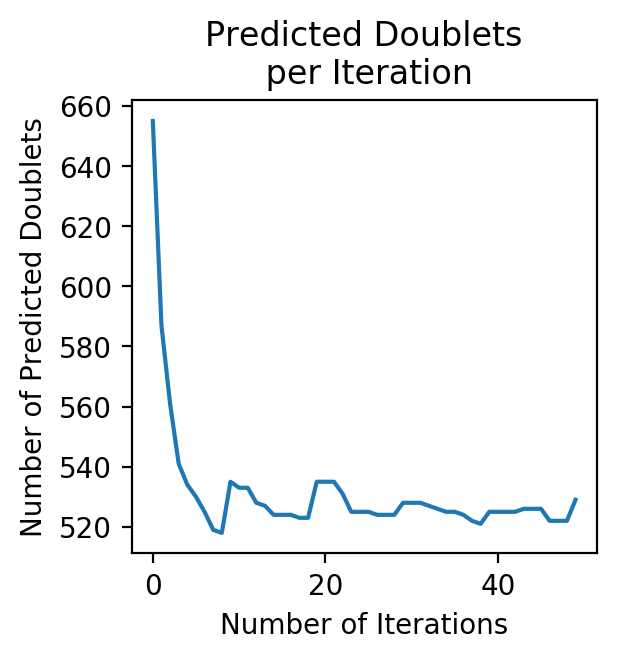

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True)

### Doublets on tSNE map

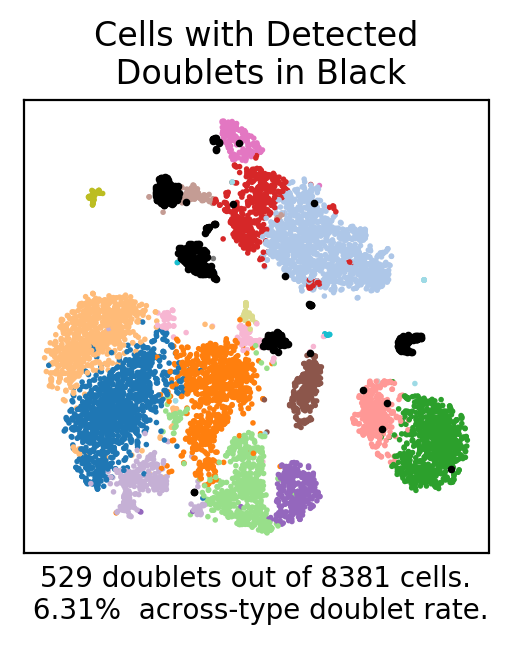

In [7]:
f2, tsne_coords = doubletdetection.plot.tsne(raw_counts, doublets, save='tsne_test.pdf', show=True)